In [1]:
import sympy as sp
import time
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import math

In [51]:
#write units for below variables
values = {
    'F': 1, #m^3/hr
    'CAf': 10, #kgmol/m^3
    'V' :1,#m^3
    'UA': 150, #kcal/degC-hr
    'k0' : 36*1e6, #h-1
    'Tj0' : 298, #K
    '-delH': 6500, #kcal/kgmol
    'rhojCj': 600, #kcal/m^3-degC
    'E' : 12000, #kcal/kgmol
    'Fj' :1.25, #m^3/hr
    'rhoCp': 500, #kcal/m^3-degC
    "Vj" : 0.25, #m^3
    'Tf' : 298, #K
    'R': 1.987 #kcal/kgmol-K
}

In [52]:
F, C_Af, V, UA, k0, Tj0, neg_delH, rhojCj, E, Fj, rhoCp, Vj, Tf, C_a, T, Tj, r, R = sp.symbols('F C_Af V UA k0 T_j0 -delH rho_jC_j E F_j rhoCp V_j T_f C_a T T_j r R', real = True)

In [53]:
r = sp.exp(-E/(R*T))*C_a*k0*1.0
r

1.0*C_a*k0*exp(-E/(R*T))

In [54]:
f_1 = 1.0*(F*C_Af - F*C_a - r*V)
f_1

1.0*C_Af*F - 1.0*C_a*F - 1.0*C_a*V*k0*exp(-E/(R*T))

In [55]:
f_2 = 1.0*(rhoCp*F*(Tf-T) - UA*(T-Tj) + r*V*neg_delH)
f_2

1.0*-delH*C_a*V*k0*exp(-E/(R*T)) + 1.0*F*rhoCp*(-T + T_f) - 1.0*UA*(T - T_j)

In [70]:
f_3 = 1.0*(rhojCj*Fj*(Tj0-Tj) + UA*(T-Tj))
f_3

1.0*F_j*rho_jC_j*(-T_j + T_j0) + 1.0*UA*(T - T_j)

In [71]:
#Generating a matrix of the equations
f = sp.Matrix([f_1, f_2, f_3])
f

Matrix([
[                         1.0*C_Af*F - 1.0*C_a*F - 1.0*C_a*V*k0*exp(-E/(R*T))],
[1.0*-delH*C_a*V*k0*exp(-E/(R*T)) + 1.0*F*rhoCp*(-T + T_f) - 1.0*UA*(T - T_j)],
[                           1.0*F_j*rho_jC_j*(-T_j + T_j0) + 1.0*UA*(T - T_j)]])

In [72]:
#Generating Jacobian matrix
J = sp.Matrix([f_1, f_2, f_3]).jacobian([C_a, T, Tj])
J

Matrix([
[-1.0*F - 1.0*V*k0*exp(-E/(R*T)),                             -1.0*C_a*E*V*k0*exp(-E/(R*T))/(R*T**2),                          0],
[   1.0*-delH*V*k0*exp(-E/(R*T)), 1.0*-delH*C_a*E*V*k0*exp(-E/(R*T))/(R*T**2) - 1.0*F*rhoCp - 1.0*UA,                     1.0*UA],
[                              0,                                                             1.0*UA, -1.0*F_j*rho_jC_j - 1.0*UA]])

In [73]:
f = f.subs([
    (F, values['F']),
    (C_Af, values['CAf']),
    (V, values['V']),
    (UA, values['UA']),
    (k0, values['k0']),
    (Tj0, values['Tj0']),
    (neg_delH, values['-delH']),
    (rhojCj, values['rhojCj']),
    (E, values['E']),
    (Fj, values['Fj']),
    (rhoCp, values['rhoCp']),
    (Vj, values['Vj']),
    (Tf, values['Tf']),
    (R, values['R'])
])
f

Matrix([
[                   -1.0*C_a - 36000000.0*C_a*exp(-6039.25515853045/T) + 10.0],
[234000000000.0*C_a*exp(-6039.25515853045/T) - 650.0*T + 150.0*T_j + 149000.0],
[                                              150.0*T - 900.0*T_j + 223500.0]])

In [74]:
J = J.subs([
    (F, values['F']),
    (C_Af, values['CAf']),
    (V, values['V']),
    (UA, values['UA']),
    (k0, values['k0']),
    (Tj0, values['Tj0']),
    (neg_delH, values['-delH']),
    (rhojCj, values['rhojCj']),
    (E, values['E']),
    (Fj, values['Fj']),
    (rhoCp, values['rhoCp']),
    (Vj, values['Vj']),
    (Tf, values['Tf']),
    (R, values['R'])
])
J

Matrix([
[-1.0 - 36000000.0*exp(-6039.25515853045/T),            -217413185707.096*C_a*exp(-6039.25515853045/T)/T**2,      0],
[   234000000000.0*exp(-6039.25515853045/T), 1.41318570709612e+15*C_a*exp(-6039.25515853045/T)/T**2 - 650.0,  150.0],
[                                         0,                                                          150.0, -900.0]])

In [91]:
def newton_raphson(f, J, x0, l, tol = 1e-6):
    decimal_places = int(-sp.log(tol, 10).evalf()+1)
    x = x0
    iter = 0
    while True:
        iter += 1
        l.append(x[0])
        x_new = (x - (J.inv()*f).subs([(C_a, x[0]), (T, x[1]), (Tj, x[2])]))
        #rounding off to the number of decimal places in tolerance
        x_new = sp.Matrix([round(x_new[0].evalf(), decimal_places), round(x_new[1].evalf(), decimal_places), round(x_new[2].evalf(), decimal_places)])
        if (abs(x_new[0]-x[0])+abs(x_new[1]-x[1])+abs(x_new[2]-x[2])) < tol:
            break
        x = x_new
    l.append(iter)
    return x_new

Matrix([[8.9685614], [308.7269610], [299.7878268]])
Time taken: 6.019582033157349


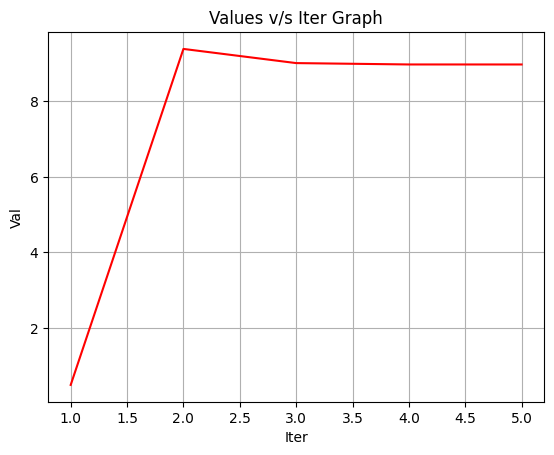

In [92]:
initial_guess = sp.Matrix([0.5, 300, 300])
tol = 1e-6
start = time.time()
l = []
print(newton_raphson(f, J, initial_guess, l, tol))
end = time.time()
print("Time taken:", end - start)
# print("i:", i)
plt.xlabel("Iter")
plt.ylabel("Val")
plt.title("Values v/s Iter Graph")
# plt.xticks(np.arange(1,11,0.5))
iter = np.arange(1, l[-1]+1)
plt.plot(iter, l[:-1], color= 'red')
plt.grid()
plt.show()

Matrix([[6.1649622], [337.8843926], [304.6473988]])
Time taken: 6.757561445236206


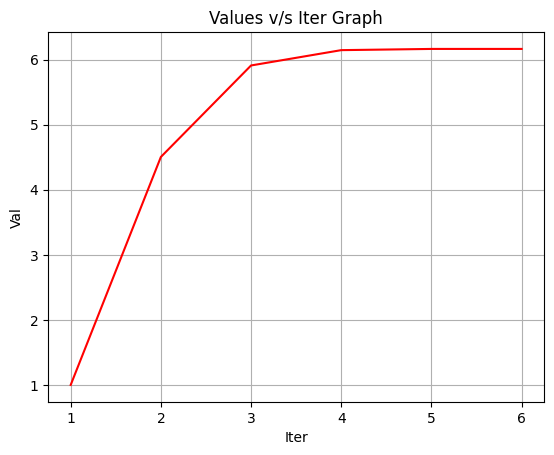

In [93]:
initial_guess = sp.Matrix([1, 350, 300])
tol = 1e-6
start = time.time()
l = []
print(newton_raphson(f, J, initial_guess, l, tol))
end = time.time()
print("Time taken:", end - start)
plt.xlabel("Iter")
plt.ylabel("Val")
plt.title("Values v/s Iter Graph")
# plt.xticks(np.arange(1,11,0.5))
iter = np.arange(1, l[-1]+1)
plt.plot(iter, l[:-1], color= 'red')
plt.grid()
plt.show()

Matrix([[1.4093933], [387.3423098], [312.8903850]])
Time taken: 7.4463934898376465


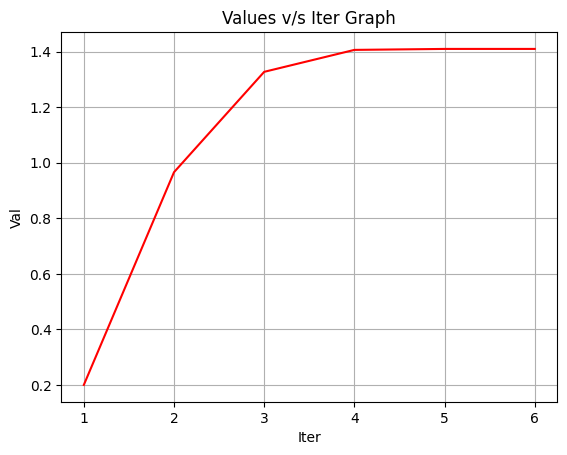

In [94]:
initial_guess = sp.Matrix([0.2, 400, 310])
tol = 1e-6
start = time.time()
l = []
print(newton_raphson(f, J, initial_guess, l, tol))
end = time.time()
print("Time taken:", end - start)
plt.xlabel("Iter")
plt.ylabel("Val")
plt.title("Values v/s Iter Graph")
# plt.xticks(np.arange(1,11,0.5))
iter = np.arange(1, l[-1]+1)
plt.plot(iter, l[:-1], color= 'red')
plt.grid()
plt.show()

Matrix([[6.1649622], [337.8843926], [304.6473988]])
Time taken: 7.139143466949463


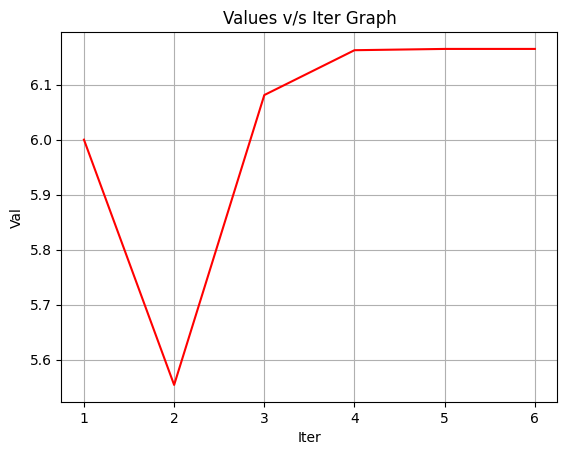

In [99]:
initial_guess = sp.Matrix([6, 350, 300])
tol = 1e-6
start = time.time()
l = []
print(newton_raphson(f, J, initial_guess, l, tol))
end = time.time()
print("Time taken:", end - start)
plt.xlabel("Iter")
plt.ylabel("Val")
plt.title("Values v/s Iter Graph")
# plt.xticks(np.arange(1,11,0.5))
iter = np.arange(1, l[-1]+1)
plt.plot(iter, l[:-1], color= 'red')
plt.grid()
plt.show()

In [82]:
fnew = f.subs([(C_a, x[0]), (T, x[1]), (Tj, x[2])])
fnew

Matrix([
[-0.450145653973994],
[  175.946750830975],
[           -6750.0]])

In [83]:
f

Matrix([
[                   -1.0*C_a - 36000000.0*C_a*exp(-6039.25515853045/T) + 10.0],
[234000000000.0*C_a*exp(-6039.25515853045/T) - 650.0*T + 150.0*T_j + 149000.0],
[                                              150.0*T - 900.0*T_j + 223500.0]])